In [ ]:
#%pip install scikit-learn==1.1.3 --quiet

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.1.3 which is incompatible.

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
merged_data = pd.read_csv('merged_term_data.csv')

In [2]:
def prepare_data(df, drop_columns, categorical_columns, target_column='y', test_size=0.2, random_state=42):
    # Select columns to keep
    selected_columns = [col for col in df.columns if col not in drop_columns]
    df_selected = df[selected_columns]
    
    # Create dummy variables for categorical features
    df_dummies = pd.get_dummies(df_selected, columns=categorical_columns, drop_first=True)
    
    # Split into features and target
    X = df_dummies.drop(target_column, axis=1)
    y = df_dummies[target_column]
    
    # Create train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [3]:
drop_columns = ['age', 'day', 'default']
categorical_columns = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month']
X_train, X_test, y_train, y_test = prepare_data(merged_data, drop_columns, categorical_columns)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Training label distribution:\n", y_train.value_counts(normalize=True))
print("Test label distribution:\n", y_test.value_counts(normalize=True))

Training set size: 59366
Test set size: 14842
Training label distribution:
 y
1    0.500034
0    0.499966
Name: proportion, dtype: float64
Test label distribution:
 y
0    0.500135
1    0.499865
Name: proportion, dtype: float64


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.head()

,balance,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,0.261700,0.439693,0.795106,1.377020,-0.379919,-0.26803,-0.372597,-0.202884,-0.14005,-0.238574,...,-0.345475,-0.013613,-0.234724,-0.130961,-0.381022,-0.32343,-0.10315,-0.642838,-0.263635,-0.051985
1,-0.474491,-0.606293,-0.716187,-0.726206,-0.379919,-0.26803,-0.372597,-0.202884,-0.14005,4.191573,...,-0.345475,-0.013613,-0.234724,-0.130961,-0.381022,-0.32343,-0.10315,-0.642838,-0.263635,-0.051985
2,-0.529460,-0.809047,-0.653216,-0.726206,2.632138,-0.26803,-0.372597,-0.202884,-0.14005,-0.238574,...,-0.345475,-0.013613,-0.234724,-0.130961,-0.381022,-0.32343,-0.10315,1.555602,-0.263635,-0.051985
3,-0.397489,1.180600,-0.023511,-0.726206,2.632138,-0.26803,-0.372597,-0.202884,-0.14005,-0.238574,...,-0.345475,-0.013613,-0.234724,-0.130961,-0.381022,-0.32343,-0.10315,1.555602,-0.263635,-0.051985
4,2.008260,-0.725671,1.172929,1.377020,-0.379919,-0.26803,-0.372597,-0.202884,-0.14005,-0.238574,...,-0.345475,-0.013613,-0.234724,-0.130961,-0.381022,-0.32343,-0.10315,-0.642838,-0.263635,-0.051985


In [6]:
import statsmodels.api as sm

# Add constant for intercept
X_train_sm = sm.add_constant(X_train_scaled)

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Display model summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.166705
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59366
Model:                          Logit   Df Residuals:                    59332
Method:                           MLE   Df Model:                           33
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.7595
Time:                        20:09:46   Log-Likelihood:                -9896.6
converged:                       True   LL-Null:                       -41149.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0665      0.040     51.741      0.000       1.988       2.145
x1             0.4615      0.

ROC AUC Score: 0.9831


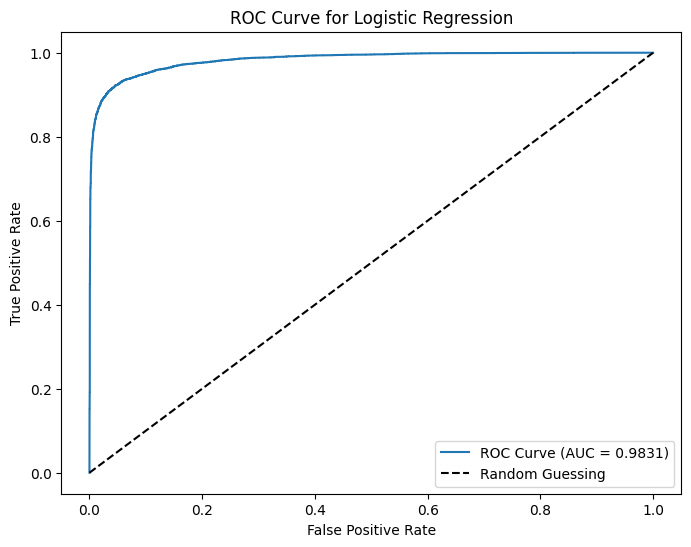

In [8]:
log_predictions = result.predict(sm.add_constant(X_test_scaled))
from sklearn.metrics import roc_auc_score, roc_curve
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, log_predictions)    
print(f"ROC AUC Score: {roc_auc:.4f}")
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, log_predictions)
plt.figure(figsize=(8, 6))  
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()

In [9]:
accuracy = result.prsquared
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.7595


In [44]:
features = X_train_scaled_df.columns

In [8]:
# The logistic regression summary table from statsmodels includes an intercept (const) and then the features in the order they appear in X_train_scaled.
# The variable 'features' contains the column names of X_train_scaled_df, which matches the order of variables in the summary table after 'const'.

# Create a list of variable names as they appear in the summary table
logit_summary_variables = ['const'] + list(features)

# Display the mapping
for idx, var in enumerate(logit_summary_variables):
    print(f"x{idx}: {var}")

x0: const
x1: balance
x2: duration
x3: campaign
x4: job_blue-collar
x5: job_entrepreneur
x6: job_housemaid
x7: job_management
x8: job_retired
x9: job_self-employed
x10: job_services
x11: job_student
x12: job_technician
x13: job_unemployed
x14: job_unknown
x15: marital_married
x16: marital_single
x17: education_secondary
x18: education_tertiary
x19: education_unknown
x20: housing_yes
x21: loan_yes
x22: contact_telephone
x23: contact_unknown
x24: month_aug
x25: month_dec
x26: month_feb
x27: month_jan
x28: month_jul
x29: month_jun
x30: month_mar
x31: month_may
x32: month_nov
x33: month_oct


In [9]:
features

Index(['balance', 'duration', 'campaign', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.5, 0.75, 1.0]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Best estimator
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Feature importances
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 1000}
                Feature  Importance
2              campaign    0.487853
1              duration    0.284238
0               balance    0.094232
4      job_entrepreneur    0.015771
11       job_technician    0.012638
6        job_management    0.010431
22      contact_unknown    0.009054
3       job_blue-collar    0.009026
17   education_tertiary    0.006690
27            month_jul    0.006502
14      marital_married    0.005974
19          housing_yes    0.005666
23            month_aug    0.004766
9          job_services    0.004529
31            month_nov    0.004272
30            month_may    0.004154
28            month_jun    0.004095
16  education_secondary    0.004043
5         job_housemaid    0.003817
15       marital_single    0.003588
20             loan_yes    0.003280
29            month_mar    0.002809
25            month_feb    0.001993
21    contact_telephone    0.0018

NameError: name 'X_test_scaled' is not defined

Accuracy on validation set: 0.9429


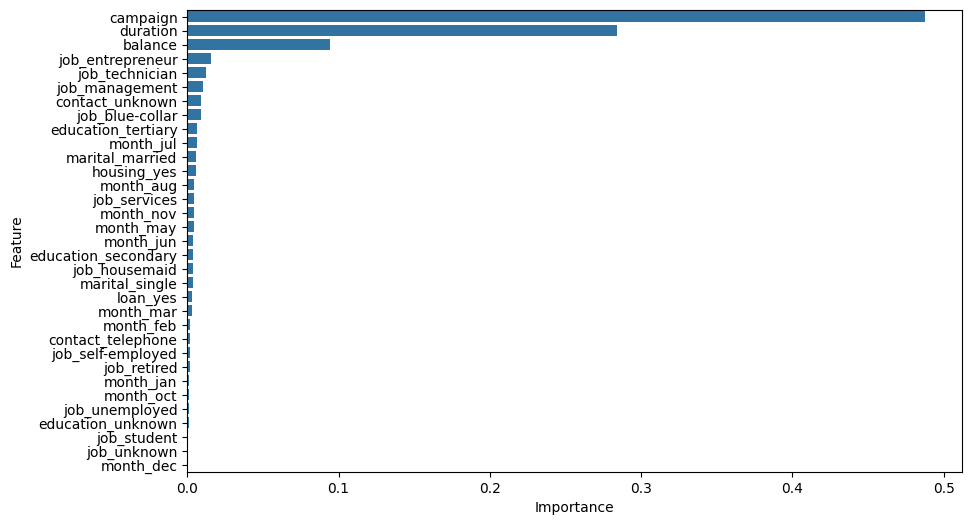

In [29]:
print(f"Accuracy on validation set: {best_rf.score(X_test_scaled, y_test):.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
#Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df
)

plt.show()

c:\Users\samar\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:14:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 7, 'gamma': 0, 'eta': 0.05, 'colsample_bytree': 0.5}
Number of features: 33
Number of examples: 59366
                Feature  Importance
2              campaign    0.186684
1              duration    0.070699
4      job_entrepreneur    0.054207
11       job_technician    0.047768
22      contact_unknown    0.041798
29            month_mar    0.039696
26            month_jan    0.039099
9          job_services    0.038463
6        job_management    0.036085
23            month_aug    0.035804
27            month_jul    0.033065
5         job_housemaid    0.032272
31            month_nov    0.031655
3       job_blue-collar    0.029312
12       job_unemployed    0.026731
8     job_self-employed    0.026209
32            month_oct    0.025843
0               balance    0.020861
28            month_jun    0.019742
17   education_tertiary    0.018058
19          housing_yes    0.015912
21    contact_telephone    0.014869


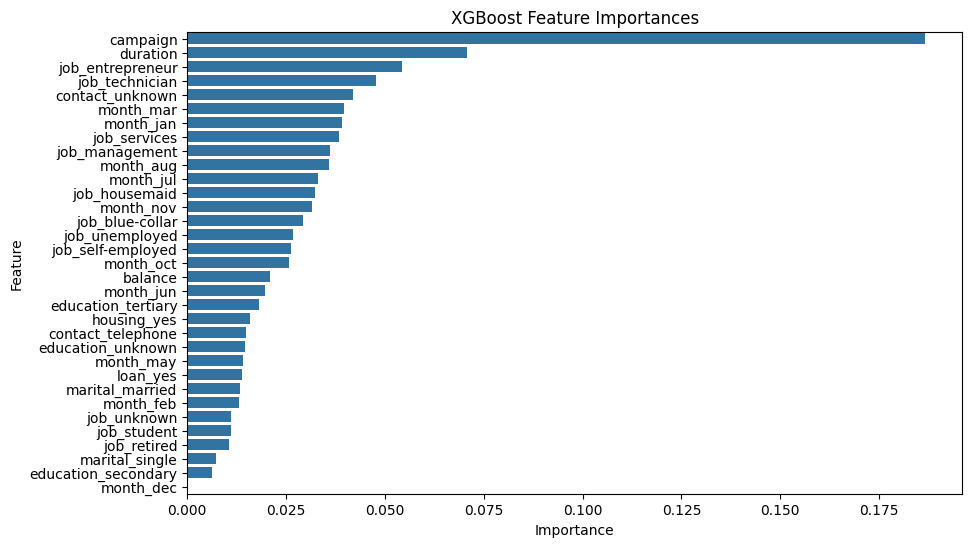

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'max_depth': [3, 5, 7, None],
    'subsample': [0.5, 0.75, 1.0]
}


xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

best_xgb = random_search.best_estimator_
test_score = best_xgb.score(X_test_scaled, y_test)

# Feature importance
xgb_importances = best_xgb.feature_importances_
xgb_feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

print("Best parameters:", random_search.best_params_)
print("Number of features:", X_train.shape[1])
print("Number of examples:", X_train.shape[0])
print(xgb_feature_importance_df)
print(f"Test set accuracy: {test_score:.4f}")


plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=xgb_feature_importance_df
)
plt.title('XGBoost Feature Importances')
plt.show()

From the hyperparameter tuned experiments using random forest and xgboost models above, it is clear that **campaign**, **duration**, **job_entrepreneur**, **job_technician**, **contact_unknown** and **job_management** can be important features that can help in classification.

In [24]:
reduced_features = xgb_feature_importance_df[xgb_feature_importance_df['Importance'] > 0.01]['Feature'].tolist()
print("Reduced feature set:", reduced_features)

# Select only the reduced features from the scaled DataFrames
x_train_reduced_scaled = X_train_scaled_df[reduced_features]
x_test_reduced_scaled = pd.DataFrame(X_test_scaled, columns=features)[reduced_features]

# Fit the best_xgb model on the reduced training data
best_xgb.fit(x_train_reduced_scaled, y_train)

# Evaluate accuracy on the reduced test data
reduced_test_accuracy = best_xgb.score(x_test_reduced_scaled, y_test)
print(f"Accuracy on reduced test set: {reduced_test_accuracy:.4f}")

Reduced feature set: ['campaign', 'duration', 'job_entrepreneur', 'job_technician', 'contact_unknown', 'month_mar', 'month_jan', 'job_services', 'job_management', 'month_aug', 'month_jul', 'job_housemaid', 'month_nov', 'job_blue-collar', 'job_unemployed', 'job_self-employed', 'month_oct', 'balance', 'month_jun', 'education_tertiary', 'housing_yes', 'contact_telephone', 'education_unknown', 'month_may', 'loan_yes', 'marital_married', 'month_feb', 'job_unknown', 'job_student', 'job_retired']


c:\Users\samar\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on reduced test set: 0.9488


In [26]:
%pip install optuna==3.5.0 --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define feature combinations
feature_combos = {
    'All features': features.tolist(),
    'Reduced features': reduced_features,
    'Smaller combo': ['campaign', 'duration','job_entrepreneur', 'job_technician', 'contact_unknown', 'job_management']
}

optuna_results = {}

for combo_name, feats in feature_combos.items():
    def objective(trial):
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'gamma': trial.suggest_float('gamma', 0, 1.0),
            'max_depth': trial.suggest_int('max_depth', 2, 8),
            'colsample_bytree': 1.0,
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42
        }
        # Scale features
        X_train_fs = scaler.fit_transform(X_train[feats])
        X_test_fs = scaler.transform(X_test[feats])
        model = XGBClassifier(**params)
        model.fit(X_train_fs, y_train)
        preds = model.predict(X_test_fs)
        return accuracy_score(y_test, preds)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, show_progress_bar=False)
    best_params = study.best_params
    best_score = study.best_value

    # Train best model for reporting
    X_train_fs = scaler.fit_transform(X_train[feats])
    X_test_fs = scaler.transform(X_test[feats])
    best_model = XGBClassifier(
        **{**best_params, 'colsample_bytree': 1.0, 'use_label_encoder': False, 'eval_metric': 'logloss', 'random_state': 42}
    )
    best_model.fit(X_train_fs, y_train)
    val_score = accuracy_score(y_test, best_model.predict(X_test_fs))

    optuna_results[combo_name] = {
        'best_params': best_params,
        'validation_score': val_score,
        'model': best_model
    }
    print(f"Feature combo: {combo_name}")
    print(f"Best params: {best_params}")
    print(f"Validation accuracy: {val_score:.4f}\n")

[I 2025-06-17 20:33:57,833] A new study created in memory with name: no-name-3f4d2bf2-29c0-456f-b3f2-985fbc699989
[I 2025-06-17 20:33:58,285] Trial 0 finished with value: 0.9471769303328392 and parameters: {'eta': 0.07212573508923177, 'n_estimators': 240, 'gamma': 0.1057091693567962, 'max_depth': 5}. Best is trial 0 with value: 0.9471769303328392.
[I 2025-06-17 20:33:59,102] Trial 1 finished with value: 0.9483223285271527 and parameters: {'eta': 0.051741669471352364, 'n_estimators': 408, 'gamma': 0.40700783972776666, 'max_depth': 7}. Best is trial 1 with value: 0.9483223285271527.
[I 2025-06-17 20:33:59,724] Trial 2 finished with value: 0.9475138121546961 and parameters: {'eta': 0.18324516561717064, 'n_estimators': 482, 'gamma': 0.08551322442702158, 'max_depth': 4}. Best is trial 1 with value: 0.9483223285271527.
[I 2025-06-17 20:34:00,041] Trial 3 finished with value: 0.9384853793289314 and parameters: {'eta': 0.027694957195980995, 'n_estimators': 88, 'gamma': 0.6042427143904234, 'max

Feature combo: All features
Best params: {'eta': 0.051741669471352364, 'n_estimators': 408, 'gamma': 0.40700783972776666, 'max_depth': 7}
Validation accuracy: 0.9483



[I 2025-06-17 20:34:16,932] Trial 0 finished with value: 0.9458294030454116 and parameters: {'eta': 0.07971372096124514, 'n_estimators': 293, 'gamma': 0.4173611145897146, 'max_depth': 4}. Best is trial 0 with value: 0.9458294030454116.
[I 2025-06-17 20:34:17,371] Trial 1 finished with value: 0.9436059830211562 and parameters: {'eta': 0.05341319196322247, 'n_estimators': 142, 'gamma': 0.7855956045455713, 'max_depth': 5}. Best is trial 0 with value: 0.9458294030454116.
[I 2025-06-17 20:34:18,672] Trial 2 finished with value: 0.9483223285271527 and parameters: {'eta': 0.035007004393011555, 'n_estimators': 450, 'gamma': 0.018916078226845046, 'max_depth': 8}. Best is trial 2 with value: 0.9483223285271527.
[I 2025-06-17 20:34:19,453] Trial 3 finished with value: 0.9417194448187576 and parameters: {'eta': 0.023011403823676467, 'n_estimators': 423, 'gamma': 0.7893974701751452, 'max_depth': 4}. Best is trial 2 with value: 0.9483223285271527.
[I 2025-06-17 20:34:19,919] Trial 4 finished with va

Feature combo: Reduced features
Best params: {'eta': 0.035007004393011555, 'n_estimators': 450, 'gamma': 0.018916078226845046, 'max_depth': 8}
Validation accuracy: 0.9483



[I 2025-06-17 20:34:37,557] Trial 0 finished with value: 0.9257512464627409 and parameters: {'eta': 0.02504454748493429, 'n_estimators': 363, 'gamma': 0.4495234086192458, 'max_depth': 5}. Best is trial 0 with value: 0.9257512464627409.
[I 2025-06-17 20:34:37,803] Trial 1 finished with value: 0.9257512464627409 and parameters: {'eta': 0.2714042201695359, 'n_estimators': 408, 'gamma': 0.6809304223217205, 'max_depth': 5}. Best is trial 0 with value: 0.9257512464627409.
[I 2025-06-17 20:34:38,051] Trial 2 finished with value: 0.9263576337420832 and parameters: {'eta': 0.16444629436815106, 'n_estimators': 415, 'gamma': 0.3285550230070209, 'max_depth': 5}. Best is trial 2 with value: 0.9263576337420832.
[I 2025-06-17 20:34:38,351] Trial 3 finished with value: 0.9246732246327988 and parameters: {'eta': 0.03463874198703606, 'n_estimators': 171, 'gamma': 0.3294430054256944, 'max_depth': 7}. Best is trial 2 with value: 0.9263576337420832.
[I 2025-06-17 20:34:38,571] Trial 4 finished with value: 

Feature combo: Smaller combo
Best params: {'eta': 0.07684514360468066, 'n_estimators': 212, 'gamma': 0.8624923414229155, 'max_depth': 4}
Validation accuracy: 0.9268



              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7423
           1       0.96      0.92      0.94      7419

    accuracy                           0.94     14842
   macro avg       0.94      0.94      0.94     14842
weighted avg       0.94      0.94      0.94     14842



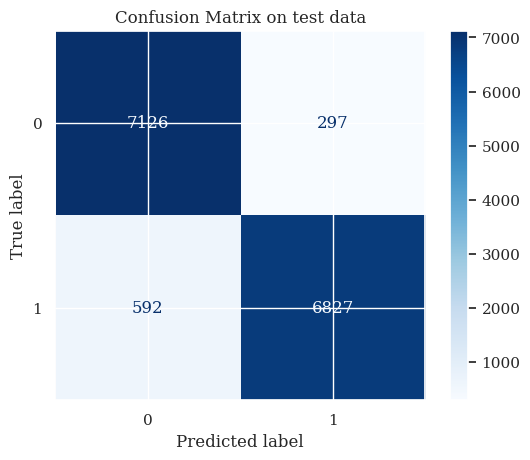

['xgb_model_reduced_features.pkl']

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
plt.rcParams['font.family'] = 'serif'

# Prepare the data
selected_feats = reduced_features  # Use the reduced features from the previous step
X_train_fs = scaler.fit_transform(X_train[selected_feats])
X_test_fs = scaler.transform(X_test[selected_feats])

# Train the XGBoost model with given parameters
xgb_model = XGBClassifier(
    eta=0.027982122895543676,
    n_estimators=82,
    gamma=0.6284233622363933,
    max_depth=8,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_fs, y_train)

# Predict on validation set
y_pred = xgb_model.predict(X_test_fs)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on test data")
plt.grid('off')
plt.show()

import joblib

# Save the trained XGBoost model to a .pkl file
joblib.dump(xgb_model, "xgb_model_reduced_features.pkl")